In [1]:
import json
from cv2 import resize
import numpy as np, matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import geometry
import pickle
from house import House
import pandas as pd
import PIL
import os
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
sns.set_style()
PIL.Image.MAX_IMAGE_PIXELS = None

header = ['ID', 'x', 'y', 'z', 'height2', 'rx', 'ry', 'rz',
          'pos1', 'pos2', 'pos3', 'att1', 'att2', 'att3', 'week', 'ToW', 'n_sat',
          'PDOP', 'lat', 'long', 'height']
ny, nx = 26460, 17004
metadata = pd.read_table(r'ims/aerial_photos/GNSSINS/EO_V355_TT-14525V_20210727_1.txt', comment='#', delim_whitespace=True, names=header)
metadata[['rx', 'ry', 'rz']] = metadata[['rx', 'ry', 'rz']].apply(np.deg2rad)
focal_length = int(100.5*1e-3/4e-6) # image coordinates
ppa = np.array((nx/2 + int(0.08*1e-3/4e-6), ny/2)) # image coordinates


def reverse_resample(coords_final, im_coords):
    pad = 15
    nudge = np.array((13, 20))
    c_min = np.min(im_coords, axis=1).astype(int)
    c_max = np.max(im_coords, axis=1).astype(int)
    ext = np.array((c_max[0]-c_min[0], c_max[1]-c_min[1]))
    if ext[0] > ext[1]:
        sq_pad = np.array((0, (ext[0]-ext[1])/2)).astype(int)
    else:
        sq_pad = np.array(((ext[1]-ext[0])/2, 0)).astype(int)

    im_ext = ext+3*pad +2*sq_pad+nudge

    coords_rev = np.swapaxes(coords_final*im_ext[::-1]/256 + c_min.reshape(1, -1) - pad - nudge.reshape(1, -1) - sq_pad.reshape(1, -1), 0, 1)

    return coords_rev


def RotationMatrix(rx, ry, rz):
    R1 = np.array([[1, 0, 0],
                   [0, np.cos(rx), -np.sin(rx)],
                   [0, np.sin(rx),np.cos(rx)]])
    
    R2 = np.array([[np.cos(ry), 0, np.sin(ry)],
                   [0, 1, 0],
                   [-np.sin(ry), 0, np.cos(ry)]])
    
    R3 = np.array([[np.cos(rz), -np.sin(rz), 0],
                   [np.sin(rz), np.cos(rz), 0],
                   [0, 0, 1]])
    
    return R1@R2@R3 

def Camera_matrix(image_id):
    cx, cy, cz, rx, ry, rz =  [metadata.loc[image_id][i] for i in ['x', 'y', 'z', 'rx', 'ry', 'rz']]
    R = RotationMatrix(rx, ry, rz) #camera rotation in w.r.t UTM
    C = np.array((cx, cy, cz)).reshape(-1, 1) #camera postion in UTM
    extrinsic_matrix = np.vstack([np.hstack([R.T, -R.T@C]),np.array((0, 0, 0, 1))])
    intrinsic_matrix = np.array(((focal_length, 0, ppa[0], 0),(0, focal_length, ppa[1], 0),(0, 0, 1, 0)))

    return intrinsic_matrix@extrinsic_matrix

def triangulate_Npts(pt2d_CxPx2, P_Cx3x4):
    """
    Triangulate multiple 3D points from two or more views by DLT.
    """

    assert pt2d_CxPx2.ndim == 3
    assert P_Cx3x4.ndim == 3
    Nc, Np, _ = pt2d_CxPx2.shape
    assert P_Cx3x4.shape == (Nc, 3, 4)

    # P0 - xP2
    x = P_Cx3x4[:,0,:][:,None,:] - np.einsum('ij,ik->ijk', pt2d_CxPx2[:,:,0], P_Cx3x4[:,2,:])
    # P1 - yP2
    y = P_Cx3x4[:,1,:][:,None,:] - np.einsum('ij,ik->ijk', pt2d_CxPx2[:,:,1], P_Cx3x4[:,2,:])

    Ab = np.concatenate([x, y])
    Ab = np.swapaxes(Ab, 0, 1)
    assert Ab.shape == (Np, Nc*2, 4)

    A = Ab[:,:,:3]
    b = - Ab[:,:,3]
    AtA = np.linalg.pinv(A)

    X = np.einsum('ijk,ik->ij', AtA, b)
    return X

def viz(corners, edges, ax, node_color='red', edge_color='darkorange'):
        corners = np.swapaxes(corners, 0, 1)
        for edge in edges:
                try:
                    ax.plot([corners[edge[0]][0], corners[edge[1]][0]], [corners[edge[0]][1], corners[edge[1]][1]],c=edge_color, zorder=2)
                except IndexError:
                     pass
        for i, corner in enumerate(corners):
            ax.scatter(*corner, c=node_color, s=9, zorder=3)


def viz_utm(house, ax, dims=[0, 2]):
    coords = house.utm_coords
    for i in range(len(house.utm_edges)):
        corner = coords[:,i]
        edges = np.swapaxes(house.utm_edges[i], 0, 1)
        for edge in edges:
            ax.plot([corner[dims[0]], edge[dims[0]]], [corner[dims[1]], edge[dims[1]]], c='lightsteelblue', zorder=0)
        ax.scatter(corner[dims[0]], corner[dims[1]], c='midnightblue', s=9, zorder=1)


[1, 2, 3, 4]
[72, 73, 74, 75]


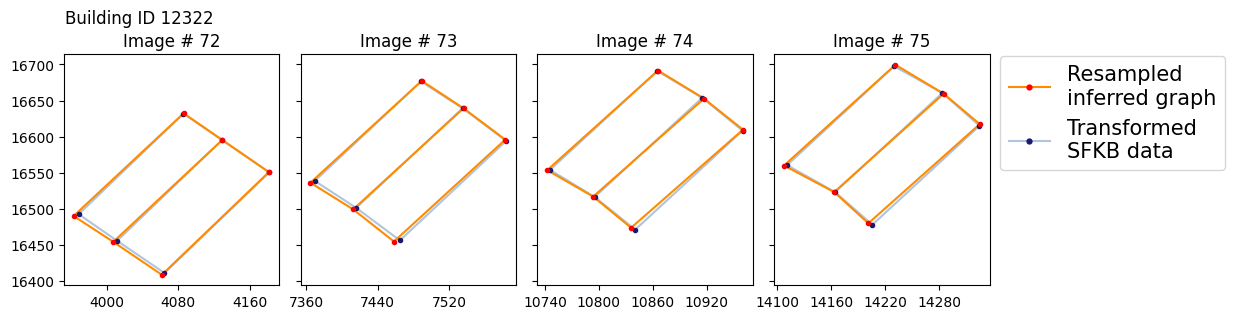

In [10]:
id = 12322
root_path = 'test_output/reproject_set/{}'.format(id)
with open (root_path + '/house.pickle', 'rb') as file:
    house = pickle.load(file)
im_ids = list()
resampled = list()
inds = list()

with open(root_path + '/inc_list.txt', 'r') as inc_file:
    for i, line in enumerate(inc_file):
        if line.endswith('\n'):
            inds.append(int(line[:-1]))
        else:
            inds.append(int(line))
print(inds)
nviews = len(inds)
heat_error = list()
order = list()
with open(root_path + '/test_list.txt', 'r') as id_file:
    for i, line in enumerate(id_file):
        if i in inds:
            id_ = int(line)
            im_ids.append(id_)
            house_tr = np.load(root_path +'/results/viz/{}_results.npy'.format(i), allow_pickle=True).item()
            an = np.array(list(np.load(root_path +'/annot/{}.npy'.format(id_), allow_pickle=True).item().keys()))
            ord = np.array(np.argmin(cdist(an, house_tr['corners']), axis=0), dtype=int)
            h_tr = house_tr['corners']
            an = an[ord]
            order.append(ord)
            heat_error.append(np.mean(np.linalg.norm(h_tr - an, axis=1)))
            im_coords = house.image_coords[0][i] 
            re = reverse_resample(h_tr, im_coords)
            resampled.append(re)

npts = house.image_coords[0][0].shape[1]
x_gt_tr = np.empty((nviews, npts, 2))
P_gt = np.empty((nviews, 3, 4))
for i, id_ in enumerate(im_ids):
    x_gt_tr[i] = np.swapaxes(resampled[i], 0, 1)
    P_gt[i] = Camera_matrix(id_)

true_utm_hom = np.vstack([house.utm_coords, np.ones(npts)])
im_tr = P_gt[0]@true_utm_hom
im_tr = im_tr[:-1, :]/im_tr[-1]


fig, axs = plt.subplots(1, 5, figsize=(3*5, 3), sharey=True)
x_gt_tr[:, :, 0] -= nx*np.ones(x_gt_tr[:,:,0].shape)
x_gt_tr[:, :, 0] *= -1
im_trs = np.empty(x_gt_tr.shape)
print(im_ids)
image_error = list()
for i, ax in enumerate(axs.flatten()[:-1]):
    im_tr = P_gt[i]@true_utm_hom
    im_tr = im_tr[:-1, :]/im_tr[-1]
    im_trs[i] = np.swapaxes(im_tr, 0, 1)
    #im_tr[0] -= nx*np.ones(im_tr[0].shape)
    #im_tr[0] *= -1
    ax.set_title('Image # {}'.format(im_ids[i]))
    image_error.append(np.mean(np.linalg.norm(np.swapaxes(x_gt_tr[i], 0, 1) - im_tr[:, order[i]], axis=1)))
    viz(im_tr[:, order[i]], house_tr['edges'], ax, node_color='midnightblue', edge_color='lightsteelblue')
    viz(np.swapaxes(x_gt_tr[i], 0, 1), house_tr['edges'], ax)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
legend_elements = [Line2D([0], [0], color='darkorange', lw=1.5,marker='.' ,markersize=7 ,markerfacecolor='red', markeredgecolor='red', label='Resampled\ninferred graph'),
                   Line2D([0], [0], color='lightsteelblue', lw=1.5,marker='.' ,markersize=7 ,markerfacecolor='midnightblue',markeredgecolor='midnightblue', label='Transformed\nSFKB data')]

axs[-1].legend(handles=legend_elements, loc=(-0.05, 0.5), fontsize=15)
axs[-1].axis('off')
fig.suptitle('Building ID {}'.format(id),x=0.175, y=1.03)
fig.subplots_adjust(wspace=0.1)


HEAT error:            [2.438655468143743, 3.123648854486199, 2.244120162478789, 2.3696784959450095]
Image error:           [5.7887795004270775, 6.61473566209577, 4.700962962079401, 4.879440096654914]
Reconstruction Error:  [0.33245195 0.62152315 0.54955544 0.20829432 0.23495368 0.19308689]


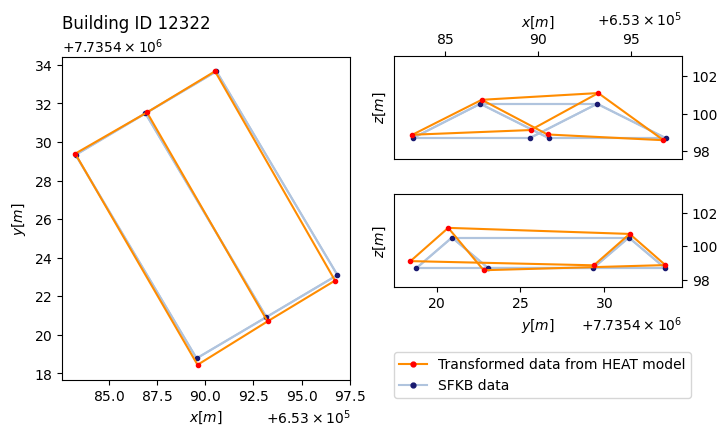

In [5]:
import matplotlib.ticker as mticker

yformatter = mticker.ScalarFormatter(useMathText=True)
xformatter0 = mticker.ScalarFormatter(useMathText=True)
xformatter1 = mticker.ScalarFormatter(useMathText=True)
xformatter2 = mticker.ScalarFormatter(useMathText=True)
re_utm_tr = np.swapaxes(triangulate_Npts(x_gt_tr, P_gt), 0, 1)
true_utm = house.utm_coords
ord = np.array(np.argmin(distance_matrix(np.swapaxes(re_utm_tr, 0, 1), np.swapaxes(true_utm, 0, 1)), axis=1), dtype=int)
true_utm = true_utm[:, ord]
recon_err = (np.linalg.norm(re_utm_tr- true_utm, axis=0))

fig, ax = plt.subplot_mosaic([['A', 'B'], ['A', 'C']], figsize=(8, 5))

ax['A'].set_aspect('equal', adjustable='box')
#ax['A'].scatter(re_utm_tr[0], re_utm_tr[1] )
viz(re_utm_tr[:-1], house_tr['edges'], ax['A'])
viz_utm(house, ax['A'],dims=[0, 1])
ax['A'].set_ylabel(r'$y[m]$')
ax['A'].set_xlabel(r'$x[m]$')
ax['A'].yaxis.set_major_formatter(yformatter)
ax['A'].xaxis.set_major_formatter(xformatter0)

ax['B'].set_xlim(np.min(re_utm_tr[0])-1, np.max(re_utm_tr[0])+1)
ax['B'].set_ylim(np.min(re_utm_tr[2])-1, np.max(re_utm_tr[2])+2)
ax['B'].set_aspect('equal', adjustable='box')
#ax['B'].scatter(re_utm_tr[0], re_utm_tr[2] )
viz_utm(house, ax['B'],dims=[0, 2])
viz(re_utm_tr[::2], house_tr['edges'], ax['B'])
ax['B'].set_ylabel(r'$z[m]$')
ax['B'].set_xlabel(r'$x[m]$')
ax['B'].yaxis.tick_right()
ax['B'].xaxis.set_label_position('top')
ax['B'].xaxis.tick_top()
ax['B'].xaxis.set_major_formatter(xformatter1)


from matplotlib.ticker import MaxNLocator
ax['C'].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

ax['C'].set_xlim(np.min(re_utm_tr[1])-1, np.max(re_utm_tr[1])+1)
ax['C'].set_ylim(np.min(re_utm_tr[2])-1, np.max(re_utm_tr[2])+2)
ax['C'].set_aspect('equal', adjustable='box')
#ax['C'].scatter(re_utm_tr[1], re_utm_tr[2] )
viz_utm(house, ax['C'],dims=[1, 2])
viz(re_utm_tr[1:], house_tr['edges'], ax['C'])
ax['C'].set_ylabel(r'$z[m]$')
ax['C'].set_xlabel(r'$y[m]$')
ax['C'].yaxis.tick_right()
ax['C'].xaxis.set_major_formatter(xformatter2)

ax['B'].set_anchor((0.6, 0.58))
ax['C'].set_anchor((0.6, 1.5))

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='darkorange', lw=1.5,marker='.' ,markersize=7 ,markerfacecolor='red', markeredgecolor='red', label='Transformed data from HEAT model'),
                   Line2D([0], [0], color='lightsteelblue', lw=1.5,marker='.' ,markersize=7 ,markerfacecolor='midnightblue',markeredgecolor='midnightblue', label='SFKB data')]

ax['C'].legend(handles=legend_elements, loc=(0, -1.2))
plt.subplots_adjust(wspace=0.15)
ax['A'].set_title('Building ID {}'.format(id), loc='left')
print('HEAT error:           ', heat_error)
print('Image error:          ', image_error)
print('Reconstruction Error: ', recon_err)
plt.savefig(root_path + '/figures/recon')

In [8]:
x_gt_tr.shape

(4, 6, 2)

HEAT error:            [2.438655468143743, 3.123648854486199, 2.244120162478789, 2.3696784959450095]
Image error:           [5.7887795004270775, 6.61473566209577, 4.700962962079401, 4.879440096654914]
Reconstruction Error:  [7.38822223e-09 9.80251664e-09 3.32943051e-09 6.32770623e-09
 4.21681932e-09 7.08490934e-09]


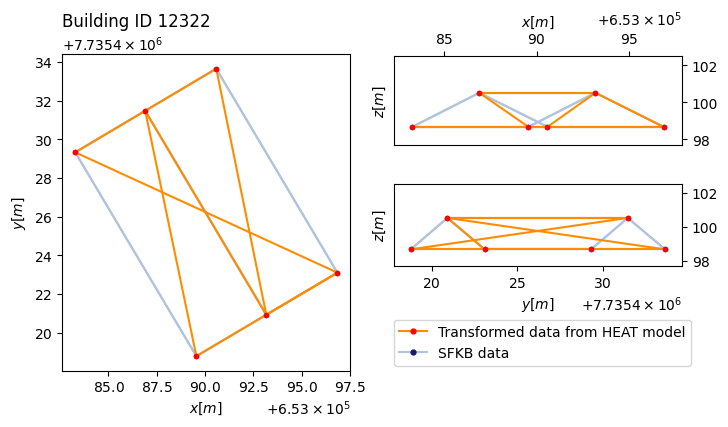

In [11]:
import matplotlib.ticker as mticker

yformatter = mticker.ScalarFormatter(useMathText=True)
xformatter0 = mticker.ScalarFormatter(useMathText=True)
xformatter1 = mticker.ScalarFormatter(useMathText=True)
xformatter2 = mticker.ScalarFormatter(useMathText=True)
re_utm_tr = np.swapaxes(triangulate_Npts(im_trs, P_gt), 0, 1)
true_utm = house.utm_coords
ord = np.array(np.argmin(distance_matrix(np.swapaxes(re_utm_tr, 0, 1), np.swapaxes(true_utm, 0, 1)), axis=1), dtype=int)
true_utm = true_utm[:, ord]
recon_err = (np.linalg.norm(re_utm_tr- true_utm, axis=0))

fig, ax = plt.subplot_mosaic([['A', 'B'], ['A', 'C']], figsize=(8, 5))

ax['A'].set_aspect('equal', adjustable='box')
#ax['A'].scatter(re_utm_tr[0], re_utm_tr[1] )
viz(re_utm_tr[:-1], house_tr['edges'], ax['A'])
viz_utm(house, ax['A'],dims=[0, 1])
ax['A'].set_ylabel(r'$y[m]$')
ax['A'].set_xlabel(r'$x[m]$')
ax['A'].yaxis.set_major_formatter(yformatter)
ax['A'].xaxis.set_major_formatter(xformatter0)

ax['B'].set_xlim(np.min(re_utm_tr[0])-1, np.max(re_utm_tr[0])+1)
ax['B'].set_ylim(np.min(re_utm_tr[2])-1, np.max(re_utm_tr[2])+2)
ax['B'].set_aspect('equal', adjustable='box')
#ax['B'].scatter(re_utm_tr[0], re_utm_tr[2] )
viz_utm(house, ax['B'],dims=[0, 2])
viz(re_utm_tr[::2], house_tr['edges'], ax['B'])
ax['B'].set_ylabel(r'$z[m]$')
ax['B'].set_xlabel(r'$x[m]$')
ax['B'].yaxis.tick_right()
ax['B'].xaxis.set_label_position('top')
ax['B'].xaxis.tick_top()
ax['B'].xaxis.set_major_formatter(xformatter1)


from matplotlib.ticker import MaxNLocator
ax['C'].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

ax['C'].set_xlim(np.min(re_utm_tr[1])-1, np.max(re_utm_tr[1])+1)
ax['C'].set_ylim(np.min(re_utm_tr[2])-1, np.max(re_utm_tr[2])+2)
ax['C'].set_aspect('equal', adjustable='box')
#ax['C'].scatter(re_utm_tr[1], re_utm_tr[2] )
viz_utm(house, ax['C'],dims=[1, 2])
viz(re_utm_tr[1:], house_tr['edges'], ax['C'])
ax['C'].set_ylabel(r'$z[m]$')
ax['C'].set_xlabel(r'$y[m]$')
ax['C'].yaxis.tick_right()
ax['C'].xaxis.set_major_formatter(xformatter2)

ax['B'].set_anchor((0.6, 0.58))
ax['C'].set_anchor((0.6, 1.5))

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='darkorange', lw=1.5,marker='.' ,markersize=7 ,markerfacecolor='red', markeredgecolor='red', label='Transformed data from HEAT model'),
                   Line2D([0], [0], color='lightsteelblue', lw=1.5,marker='.' ,markersize=7 ,markerfacecolor='midnightblue',markeredgecolor='midnightblue', label='SFKB data')]

ax['C'].legend(handles=legend_elements, loc=(0, -1.2))
plt.subplots_adjust(wspace=0.15)
ax['A'].set_title('Building ID {}'.format(id), loc='left')
print('HEAT error:           ', heat_error)
print('Image error:          ', image_error)
print('Reconstruction Error: ', recon_err)
plt.savefig(root_path + '/figures/recon')